## Importing Needed Libraries

In [1]:
import requests      # Requests data from an API
import json          # Handles JSON object
import jmespath      # Allows you to mor easily navigate JSON objects
import pandas as pd  # Handles data frames
import matplotlib.pyplot as plt


## Reviewing Structure

In [12]:
# URL for titles with artificial intelligence in them 
url_ai_works_test = \
      "https://api.openalex.org/works?filter=title.search:artificial%20intelligence"

# Obtain the JSON data of records from the open alex API
search_results_ai_works_test = requests.\
    get(url_ai_works_test).json()


In [13]:
# Write the file into a JSON file to easily view structure 
with open('json_files/search_results_ai_works_test.json', 'w') as file: 
    file.write(json.dumps(search_results_ai_works_test, indent =4))

## Pulling Needed Data for Questions 1-3

I will access the API, pull the needed data from each page, and then safe the data into a dataframe for analysis. 

In [4]:
# Define the base URL
url_ai_works = "https://api.openalex.org/works?filter=title.search:artificial%20intelligence"

# Set records per page
per_page = 200

# Empty dataframe for data 
data = []

# Initialize cursor with first page 
cursor = '*'

# Use while loop to go through each batch of results 
while cursor:
    # Get the results using cursor pagination
    search_results_temp = requests.get(f"{url_ai_works}&per-page={per_page}&cursor={cursor}").json()

    # Check if 'results' exists in search_results_temp
    if 'results' not in search_results_temp:
        print(f"No 'results' key found in search_results_temp, breaking loop. Full search_results_temp: {search_results_temp}")
        break

    # Process the current batch of results
    for work in search_results_temp['results']:
        work_id = work.get('id', 'N/A')
        title = work.get('title', 'N/A')
        display_name = work.get('display_name', 'N/A') 
        doi = work.get('doi', 'N/A')
        publication_date = work.get('publication_date', 'N/A')
        cited_by_count = work.get('cited_by_count', 'N/A')
        work_type = work.get('type', 'N/A')

        authors = []
        institutions = []
        countries = []

        if 'authorships' in work:
            for author in work['authorships']:
                authors.append(author['author']['display_name'])
                if 'institutions' in author:
                    for institution in author['institutions']:
                        institutions.append(institution.get('display_name', 'N/A'))
                if 'countries' in author:
                    for country in author['countries']:
                        countries.append(country)

        data.append({
            'ID': work_id,
            'Title': title,
            'Display Name': display_name, 
            'DOI': doi,
            'Publication Date': publication_date,
            'Cited By Count': cited_by_count,
            'Type': work_type,
            'Authors': ', '.join(authors),
            'Institutions': ', '.join(institutions),
            'Countries': ', '.join(countries)
        })

    # Check if there's a next cursor in the search_results_temp, break if not 
    if search_results_temp['meta']['next_cursor'] is None and not search_results_temp['results']:
        print("No more pages left.")
        break

    
    # Move to the next batch
    cursor = search_results_temp['meta']['next_cursor']

df_ai = pd.DataFrame(data)



No more pages left.


In [14]:
# Create a copy of the dataframe just in case 
df_ai_copy = df_ai.copy()

## Question 1

In [17]:
# Answer using dataframe created above (not meta['count'])
total_ai_works = df_ai_copy.shape[0]
print("The number of works with 'artificial intelligence' in the title is {:,}".format(total_ai_works))

The number of works with 'artificial intelligence' in the title is 139,691


In [ ]:
# Note: this was run on Oct 2nd ~5:30pm

### Answer 
The number of works with 'artificial intelligence' in the title is 139,691 as of ~6pm on Oct 2nd. 

## Question 2

For the purpose of this assignment, I will use the country associated with the first author listed for each work.

In [18]:
# Creating a column for publication year 
df_ai_copy['Publication Date'] = pd.to_datetime(df_ai_copy['Publication Date'])
df_ai_copy['Publication_Year'] = df_ai_copy['Publication Date'].dt.year


# Creating columns with information about only the first offer for the analysis 
df_ai_copy['First_Author'] = df_ai_copy['Authors'].str.split(',').str[0]
df_ai_copy['First_Author_Inst'] = df_ai_copy['Institutions'].str.split(',').str[0]
df_ai_copy['First_Author_Country'] = df_ai_copy['Countries'].str.split(',').str[0]

# Where Countries is blank, let's change it to "Not Given"
df_ai_copy['First_Author_Country'] = df_ai_copy['First_Author_Country'].replace('', 'Not Given')

In [19]:
# Filter for publications since 2020
df_ai_filtered_2020 = df_ai_copy[df_ai_copy['Publication_Year'] >= 2020]

# Group by the country and count the number of publications
country_publications = df_ai_filtered_2020.groupby('First_Author_Country').agg(Publication_Count=('First_Author_Country', 'size')).reset_index()

# Sort by the number of publications in descending order
country_publications_sorted = country_publications.sort_values(by='Publication_Count', ascending=False).reset_index(drop = True)

# Renaming columns 
country_publications_renamed = country_publications_sorted.rename(columns={
    'First_Author_Country': 'Country',
    'Publication_Count': 'Publication Count'
})

# Applying formatting to publication count 
country_publications_renamed['Publication Count'] = country_publications_renamed['Publication Count'].apply(lambda x: f"{x:,}")


# Display the table
print(country_publications_renamed[['Country', 'Publication Count']].to_string(index=False))


  Country Publication Count
Not Given            31,360
       CN            12,024
       US            11,191
       IN             8,563
       GB             3,182
       DE             2,321
       IT             2,211
       RU             2,003
       CA             1,750
       KR             1,657
       TR             1,572
       AU             1,525
       ES             1,487
       ID             1,376
       FR             1,368
       JP             1,240
       BR               996
       SA               968
       IR               899
       TW               786
       NL               759
       MY               703
       PK               655
       PL               625
       RO               571
       CH               570
       EG               555
       PT               550
       UA               519
       GR               468
       AE               466
       SG               465
       MA               422
       NG               418
       ZA           

Findings 
- Over 31k publications did not have a country associated with the Author 

Let's remove these and format a nice table for the top 10 countries

In [20]:
# Dropping rows where the value of 'Country' is equal to 'Not Given' 
country_publications_nona = country_publications_renamed[country_publications_renamed['Country'] != 'Not Given']

# Filter to top 10 countries by publications 
country_publications_top10 = country_publications_nona.iloc[0:10,:]

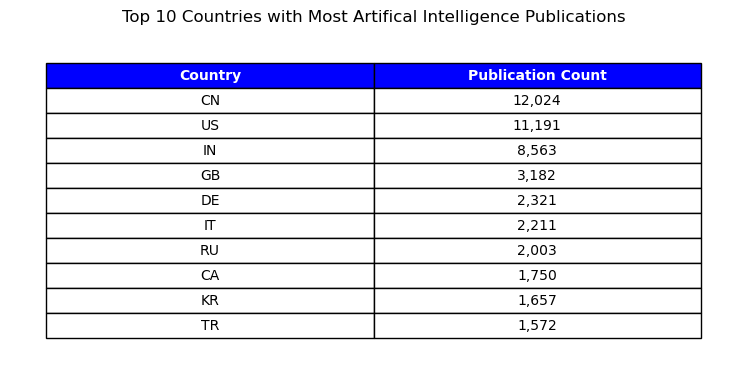

In [21]:
# Creating formatted table 
fig, list_subfig = plt.subplots(figsize = (8,4))

plt.tight_layout()
plt.subplots_adjust(wspace=0.1)


table = list_subfig.table(cellText=country_publications_top10.reset_index(drop = True).values, 
                  colLabels=country_publications_top10.columns, 
                  loc='center', cellLoc='center')

table.scale(0.9, 1.5)  
list_subfig.axis('off')
list_subfig.set_title('Top 10 Countries with Most Artifical Intelligence Publications')


# Format the table
table.auto_set_font_size(False)
table.set_fontsize(10) 

for (i, j), cell in table.get_celld().items():
    if i == 0:  # Header row
        cell.set_facecolor('blue')  
        cell.set_text_props(color='white', weight='bold', fontsize=10)  
    else:  
        pass
    cell.set_edgecolor('black')  

plt.show()

### Answer


In [22]:
# Display the table with all countries (same as above)
print(country_publications_renamed[['Country', 'Publication Count']].to_string(index=False))

  Country Publication Count
Not Given            31,360
       CN            12,024
       US            11,191
       IN             8,563
       GB             3,182
       DE             2,321
       IT             2,211
       RU             2,003
       CA             1,750
       KR             1,657
       TR             1,572
       AU             1,525
       ES             1,487
       ID             1,376
       FR             1,368
       JP             1,240
       BR               996
       SA               968
       IR               899
       TW               786
       NL               759
       MY               703
       PK               655
       PL               625
       RO               571
       CH               570
       EG               555
       PT               550
       UA               519
       GR               468
       AE               466
       SG               465
       MA               422
       NG               418
       ZA           

Findings 
- From the table with all countries (including "Not Given"), we can see that many publications did not have a country associated with the author 
- Excluding "Not Given", we can see that China had the most publications with ~12k, followed by the United States with ~11k, then India with ~8.5k
- After India, there is quite a big drop in the number of publications, indicating that China, the U.S. and India are the primary countries that produce publications on artificial intelligence


## Question 3

In [26]:
# Since each work is unqique, we don't need to do this (we could just extract the columns we wanted then sort)
papers_cited = df_ai_filtered_2020.groupby(['Title', 'Authors', 'Institutions']).agg(Citations=('Cited By Count', 'sum')).reset_index()

papers_cited_sorted = papers_cited.sort_values(by='Citations', ascending=False).reset_index(drop = True)

# Applying formatting to citation sum 
papers_cited_sorted['Citations'] = papers_cited_sorted['Citations'].apply(lambda x: f"{x:,}")


# Filter to top 10 works by publications 
papers_cited_top10 = papers_cited_sorted.iloc[0:10,:]



In [27]:
# Displaying table of top 10 
pd.set_option('display.max_colwidth', None)  # Show full content of columns
display(papers_cited_top10)

,Title,Authors,Institutions,Citations
0,Using Artificial Intelligence to Detect COVID-19 and Community-acquired Pneumonia Based on Pulmonary CT: Evaluation of the Diagnostic Accuracy,"Lin Li, Lixin Qin, Zeguo Xu, Youbing Yin, Xin Wang, Bin Kong, Junjie Bai, Yi Lu, Zhenghan Fang, Qi Song, Kunlin Cao, Daliang Liu, Guisheng Wang, Qizhong Xu, Xisheng Fang, Shiqin Zhang, Juan Xia, Jun Xia","Jianghan University, Wuhan Pulmonary Hospital, Liaocheng People's Hospital, Chinese PLA General Hospital, Shenzhen University Health Science Center, Shenzhen Second People's Hospital","1,851"
1,The role of artificial intelligence in achieving the Sustainable Development Goals,"Ricardo Vinuesa, Hossein Azizpour, Iolanda Leite, Madeline Balaam, Virginia Dignum, Sami Domisch, Anna Felländer, Simone D. Langhans, Max Tegmark, Francesco Fuso Nerini","Swedish e-Science Research Centre, KTH Royal Institute of Technology, KTH Royal Institute of Technology, KTH Royal Institute of Technology, Umeå University, Leibniz Institute of Freshwater Ecology and Inland Fisheries, Basque Centre for Climate Change, Massachusetts Institute of Technology, KTH Royal Institute of Technology","1,502"
2,"Review of Artificial Intelligence Techniques in Imaging Data Acquisition, Segmentation, and Diagnosis for COVID-19","Feng Shi, Jun Wang, Jun Shi, Ziyan Wu, Qian Wang, Zhenyu Tang, Kelei He, Yinghuan Shi, Dinggang Shen","United Imaging Healthcare (China), Shanghai University, Shanghai University, Shanghai Jiao Tong University, Beijing Advanced Sciences and Innovation Center, Beihang University, Nanjing University, Nanjing Medical University, Nanjing University, United Imaging Healthcare (China)","1,296"
3,Artificial Intelligence (AI) applications for COVID-19 pandemic,"Raju Vaishya, Mohd Javaid, Ibrahim Haleem Khan, Abid Haleem","Indraprastha Apollo Hospitals, Jamia Millia Islamia, Northeastern University, Jamia Millia Islamia","1,261"
4,A Survey on Explainable Artificial Intelligence (XAI): Toward Medical XAI,"Erico Tjoa, Cuntai Guan","Nanyang Technological University, Alibaba Group (China), Alibaba Group (China), Nanyang Technological University","1,168"
5,Artificial Intelligence in Education: A Review,"Lijia Chen, Pingping Chen, Zhijian Lin","Yango University, Fuzhou University, Fuzhou University","1,134"
6,Photonics for artificial intelligence and neuromorphic computing,"Bhavin J. Shastri, Alexander N. Tait, Thomas Ferreira de Lima, Wolfram H. P. Pernice, Harish Bhaskaran, C. David Wright, Paul R. Prucnal","Queen's University, Princeton University, Princeton University, University of Münster, University of Oxford, University of Exeter, Princeton University","1,023"
7,Artificial intelligence–enabled rapid diagnosis of patients with COVID-19,"Xueyan Mei, Hao-Chih Lee, Kaiyue Diao, Mingqian Huang, Bin Lin, Chenyu Liu, Zongyu Xie, Yixuan Ma, Philip M. Robson, Michael Chung, Adam Bernheim, Venkatesh Mani, Claudia Calcagno, Kunwei Li, Shaolin Li, Hong Shan, Jian Lv, Tongtong Zhao, Junli Xia, Qihua Long, Sharon Steinberger, Adam Jacobi, Timothy Deyer, Marta Łuksza, Fang Liu, Brent P. Little, Zahi A. Fayad, Yang Yang","Icahn School of Medicine at Mount Sinai, Icahn School of Medicine at Mount Sinai, Sichuan University, West China Hospital of Sichuan University, Icahn School of Medicine at Mount Sinai, Second Affiliated Hospital of Zhejiang University, Icahn School of Medicine at Mount Sinai, First Affiliated Hospital of Bengbu Medical College, Icahn School of Medicine at Mount Sinai, Icahn School of Medicine at Mount Sinai, Icahn School of Medicine at Mount Sinai, Icahn School of Medicine at Mount Sinai, Icahn School of Medicine at Mount Sinai, Icahn School of Medicine at Mount Sinai, Sun Yat-sen University, Fifth Affiliated Hospital of Sun Yat-sen University, Sun Yat-sen University, Fifth Affiliated Hospital of Sun Yat-sen University, Sun Yat-sen University, Fifth Affiliated Hospital of Sun Yat-sen University, Fuyang Second People's Hospital, Bozhou People's Hospital, Wuhan Uni

### Answers 

The top 10 most cited works on artificial intelligence are:
- __Using Artificial Intelligence to Detect COVID-19 and Community-acquired Pneumonia Based on Pulmonary CT: Evaluation of the Diagnostic Accuracy__
    - _Citations:_ 1,851
    - _Authors:_ Lin Li, Lixin Qin, Zeguo Xu, Youbing Yin, Xin Wang, Bin Kong, Junjie Bai, Yi Lu, Zhenghan Fang, Qi Song, Kunlin Cao, Daliang Liu, Guisheng Wang, Qizhong Xu, Xisheng Fang, Shiqin Zhang, Juan Xia, Jun Xia
    - _Institutions:_ Jianghan University, Wuhan Pulmonary Hospital, Liaocheng People's Hospital, Chinese PLA General Hospital, Shenzhen University Health Science Center, Shenzhen Second People's Hospital
- __The role of artificial intelligence in achieving the Sustainable Development Goals__
    - _Citations:_ 1,502
    - _Authors:_ Ricardo Vinuesa, Hossein Azizpour, Iolanda Leite, Madeline Balaam, Virginia Dignum, Sami Domisch, Anna Felländer, Simone D. Langhans, Max Tegmark, Francesco Fuso Nerini
    - _Institutions:_ Swedish e-Science Research Centre, KTH Royal Institute of Technology, Umeå University, Leibniz Institute of Freshwater Ecology and Inland Fisheries, Basque Centre for Climate Change, Massachusetts Institute of Technology
- __Review of Artificial Intelligence Techniques in Imaging Data Acquisition, Segmentation, and Diagnosis for COVID-19__
    - _Citations:_ 1,296
    - _Authors:_ Feng Shi, Jun Wang, Jun Shi, Ziyan Wu, Qian Wang, Zhenyu Tang, Kelei He, Yinghuan Shi, Dinggang Shen
    - _Institutions:_ United Imaging Healthcare (China), Shanghai University, Shanghai Jiao Tong University, Beijing Advanced Sciences and Innovation Center, Beihang University, Nanjing University, Nanjing Medical University
- __Artificial Intelligence (AI) applications for COVID-19 pandemic__
    - _Citations:_ 1,261
    - _Authors:_ Raju Vaishya, Mohd Javaid, Ibrahim Haleem Khan, Abid Haleem
    - _Institutions:_ Indraprastha Apollo Hospitals, Jamia Millia Islamia, Northeastern University
- __A Survey on Explainable Artificial Intelligence (XAI): Toward Medical XAI__
    - _Citations:_ 1,168
    - _Authors:_ Erico Tjoa, Cuntai Guan
    - _Institutions:_ Nanyang Technological University, Alibaba Group (China)
- __Artificial Intelligence in Education: A Review__
    - _Citations:_ 1,134
    - _Authors:_ Lijia Chen, Pingping Chen, Zhijian Lin
    - _Institutions:_ Yango University, Fuzhou University
- __Photonics for artificial intelligence and neuromorphic computing__
    - _Citations:_ 1,023
    - _Authors:_ Bhavin J. Shastri, Alexander N. Tait, Thomas Ferreira de Lima, Wolfram H. P. Pernice, Harish Bhaskaran, C. David Wright, Paul R. Prucna
    - _Institutions:_ Queen's University, Princeton University, University of Münster, University of Oxford, University of Exeter
- __Artificial intelligence–enabled rapid diagnosis of patients with COVID-19__
    - _Citations:_ 928
    - _Authors:_ Xueyan Mei, Hao-Chih Lee, Kaiyue Diao, Mingqian Huang, Bin Lin, Chenyu Liu, Zongyu Xie, Yixuan Ma, Philip M. Robson, Michael Chung, Adam Bernheim, Venkatesh Mani, Claudia Calcagno, Kunwei Li, Shaolin Li, Hong Shan, Jian Lv, Tongtong Zhao, Junli Xia, Qihua Long, Sharon Steinberger, Adam Jacobi, Timothy Deyer, Marta Łuksza, Fang Liu, Brent P. Little, Zahi A. Fayad, Yang Yang
    - _Institutions:_ Icahn School of Medicine at Mount Sinai, Sichuan University, West China Hospital of Sichuan University, Second Affiliated Hospital of Zhejiang University, First Affiliated Hospital of Bengbu Medical College, Sun Yat-sen University, Fuyang Second People's Hospital, Bozhou People's Hospital, Wuhan University, Renmin Hospital of Wuhan University, Riverview Medical Center, Fifth Affiliated Hospital of Sun Yat-sen University, Massachusetts General Hospital
- __Human Trust in Artificial Intelligence: Review of Empirical Research__
    - _Citations:_ 885
    - _Authors:_ Ella Glikson, Anita Williams Woolley
    - _Institutions:_ Bar-Ilan University, Carnegie Mellon University	
- __Comparing Physician and Artificial Intelligence Chatbot Responses to Patient Questions Posted to a Public Social Media Forum__
    - _Citations:_ 860
    - _Authors:_ John W. Ayers, Adam Poliak, Mark Dredze, Eric C. Leas, Zechariah Zhu, Jessica B. Kelley, Dennis Faix, Aaron M. Goodman, Chris Longhurst, Michael Hogarth, Davey M. Smith
    - _Institutions:_ Qualcomm (United States), University of California, San Diego, Bryn Mawr College, Johns Hopkins University, Human Longevity (United States), Naval Health Research Center


     

## Question 4

In [28]:
# Base URL
base_url2 = 'https://api.openalex.org/works'

# List of words of interest
list_words = ['artificial intelligence', 'LLM', 'GPT', 'deep learning']  
years = list(range(2000, 2024))  

# Creating a function to get the number of publications per year for a work
def get_publication_data(keyword):
    results = []
    for year in years:
        params = {
            'search': keyword,
            'filter': f'publication_year:{year}',
            'group_by': 'publication_year',
        }
        response = requests.get(base_url2, params=params)
        data = response.json()
        if 'group_by' in data:
            year_count = data['group_by'][0]['count']
        else:
            year_count = 0
        results.append({'year': year, 'keyword': keyword, 'count': year_count})
    return results


In [29]:
# Run all key words through the function 
all_data = []
for keyword in list_words:
    keyword_data = get_publication_data(keyword)
    all_data.extend(keyword_data)

# Convert to dataframe 
df_keywords = pd.DataFrame(all_data)

# Pivoting the data for plotting 
df_pivot = df_keywords.pivot(index='year', columns='keyword', values='count')

In [33]:
df_pivot_copy = df_pivot.copy()

In [36]:
# Get difference in artificial intelligence between each row for growth computation 
df_pivot_copy["diff_ai"] = df_pivot_copy["artificial intelligence"].diff()

#Create column that shifts the rows down one to be able to compute growth using columns 
df_pivot_copy["lag_ai"] = df_pivot_copy["artificial intelligence"].shift(1)

# Compute growth of artificial intelligence 
df_pivot_copy["growth_ai"] = (df_pivot_copy["diff_ai"]/df_pivot_copy["lag_ai"])* 100

Text(0.5, 1.0, 'Change in the artificial intelligence publication count')

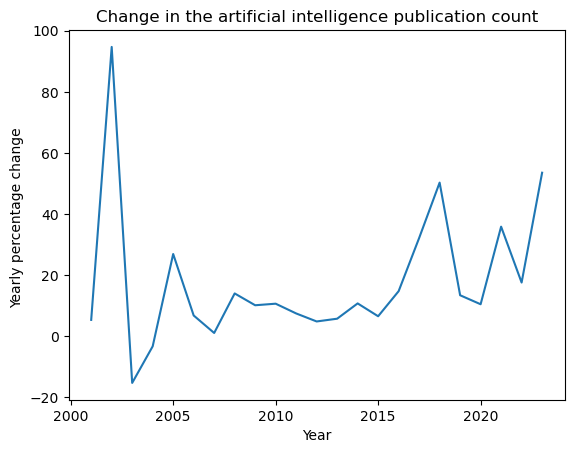

In [38]:
plt.plot(df_pivot_copy.index, "growth_ai",
          data = df_pivot_copy)
plt.xlabel("Year")
plt.ylabel("Yearly percentage change ")
plt.title("Change in the artificial intelligence publication count")

Findings: 
- There was an initial spike around 2003, where the growth percentage jumps to over 80%, indicating a dramatic increase in AI-related publications during this time; however, the spike is followed by a sharp drop, potentially indicating a saturation or correction after the initial rapid growth 
- From 2015 onwards, there was increased momentum in AI research, likely corresponding to advancements in deep learning and practical AI applications 
- The data suggests that the number of AI publications is still growing, though the rate of growth has been volatile in recent years 


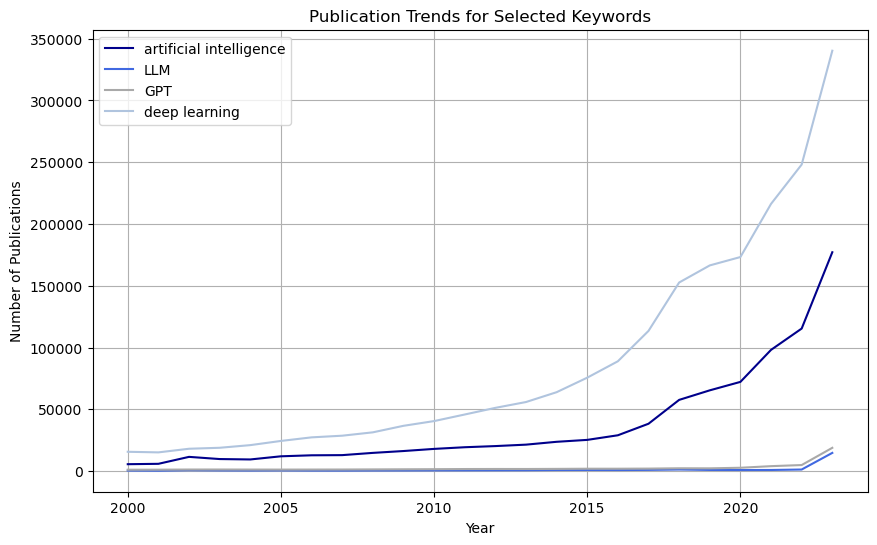

In [39]:
# Plot the results

colours = ['darkblue', 'royalblue', 'darkgrey', 'lightsteelblue']
plt.figure(figsize=(10, 6))
for i in range(len(list_words)):
    plt.plot(df_pivot.index, df_pivot[list_words[i]], label=list_words[i], color=colours[i])

    
plt.title('Publication Trends for Selected Keywords')
plt.xlabel('Year')
plt.ylabel('Number of Publications')
plt.legend()
plt.grid(True)
plt.show()

Findings:
- Artificial intelligence publications 
    - Shows steady growth from 2000 to about 2010
    - The growth rate accelerates after 2015
    - By the 2020s, the number of AI-related publications shows an upward trend
- Deep learning publications
    - Shows very little activity until around 2010
    - After 2010, there was a dramatic surge, especially post-2015
    - Appears to have the highest number of publications among the keywords
- LLM publications 
    - Relatively flat until around 2020, after which there was a noticeable rise, which matches the rise in the development and research of LLMs (such as chat GPT)
    - Although the growth is shart, the number of publications remains smaller compared to "artificial intelligence" and "deep learning"
- GPT publications
    - Similar trends to LLM publications 

### Answers

- The number of publications with "artificial intelligence" has steadily increased since 2000; from 2000 to 2015, the growth was relatively modest indicating slow and steady increases in AI-related research; post-2015, the number of "artificial intelligence" publications begins to rise more sharply, showing a surge in interest and research related to AI; the curve becomes steeper from 2020 onwards, as AI has become a central focus in research with applications in various industries 
- Deep learning has seen the most dramatic increase, especially after 2015, and now far surpasses the key words in the chart 
- In comparison, LLM and GPT are relatively new research areas, with minimal publications before 2020 
- Both LLM and GPT saw rapid growth after 2020, reflecting their rising importance in natural language processing, though their publication counts remain lower than artificial intelligence and deep learning 
- Despite the differences, all keywords show a trend of increasing research interest
